In [53]:
import csv
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
from PIL import Image
from io import BytesIO, StringIO
import matplotlib.pyplot as plt
from urllib.parse import quote
from tqdm import tqdm

In [2]:
# To be modified:

# the path to store the dataframe of the names and types
path_df_text = "test_res_scrapping"
# the path to store the folder of the images
path_image = "test_res_scrapping"

In [3]:
url = "https://www.pokepedia.fr/Liste_des_Pok%C3%A9mon_dans_l%27ordre_du_Pok%C3%A9dex_National"

In [4]:
# a Response object
# the attribute that interests us in this response in the text,
# meaning the content of the response, in Unicode format (an str)
req = requests.get(url)

In [5]:
# a BeautifulSoup object, useful to navigate in the HTML document
soup = BeautifulSoup(req.text)

# Part I: retrieving the dataframe of the names and types

In [44]:
# soup.find_all("table") outputs a BeautifulSoup subcriptable object
# (bs4.element.ResultSet) with all the tables of the webpage
all_table = soup.find_all("table")

# As the website change often, the position of the desired table can change,
# as there exists other smaller tables in the webpage
# One way to be sure to extract the good table is to extract the table which is
# the longest (when converted to str), since this table covers almost the entire web page
longest_len = 0
data = None
for table in all_table:
    table_str = str(table)
    len_table = len(table_str)
    if len_table > longest_len:
        longest_len = len_table
        data = table_str

In [45]:
# The output of the types is quite complicated because there are not only type names in
# the HTML file, but also link to images (icon) and so on
# the following function transforms the HTML file (that has been tranformed to an str)
# so that the values of types for each entry is transformed to a simpler content that can be
# be read afterwards

def replace(m : str) -> str :
    """
    Extract type names and format them
    """
    # Extract type names
    type_names = re.findall(r'title="([^"]+)"', m.group(0))

    # Remove "(type)" from each type name
    type_names = [name.replace(" (type)", "") for name in type_names]

    # Join type names with comma
    return '<td>' + ', '.join(type_names) + '</td>'


def replace_types(html : str) -> str:
    """
    Change the types of the HTML string to a more readable content
    """
    # Pattern to match the Types column HTML content
    pattern = r'<td><span typeof="mw:File">.*?</td>'

    # Replace the matched HTML with formatted type names
    return re.sub(pattern, replace, html)

In [71]:
# "read_html" outputs a list of all pandas dataframe for each table encoutered in the input
# As we previously selected the desired table directly with BeautifulSoup, there is
# only one element in the list
# To avoid a warning, read_html prefers to take as input an io file (even if the str of the
# html also works)
df_text = pd.read_html(StringIO(replace_types(data)), header=0)[0]

In [72]:
df_text.head()

,Numéro,Image,Nom français,Nom anglais,Nom allemand,Nom japonais,Nom japonais.1,Types
0,Numéro,Image,Nom français,Nom anglais,Nom allemand,Kanas,Déposé,Types
1,0001,NaN,Bulbizarre,Bulbasaur,Bisasam,フシギダネ（Fushigidane）,Fushigidane,"Plante, Poison"
2,0002,NaN,Herbizarre,Ivysaur,Bisaknosp,フシギソウ（Fushigisō）,Fushigisou,"Plante, Poison"
3,0003,NaN,Florizarre,Venusaur,Bisaflor,フシギバナ（Fushigibana）,Fushigibana,"Plante, Poison"
4,0003,NaN,Florizarre Gigamax,Venusaur Gigantamax,Bisaflor Gigadynamax,フシギバナ（Fushigibana） キョダイマックス（Kyodaimakkusu）,Fushigibana,"Plante, Poison"


In [73]:
# transforming the dataframe so that the columns and indexes are coherent

# deleting duplicate column in the first row
df_text.columns = df_text.iloc[0,:]
df_text.drop([0], inplace=True)

# renaming some columns
# The word "déposé" stands for the registered name of the Pokemon in Japan
dict_replace = {
                'Numéro' : 'Number',
                'Nom français' : 'French',
                'Nom anglais' : 'English',
                'Nom allemand' : 'German',
                'Déposé' : 'Registered'
                }
df_text.rename(columns=dict_replace, inplace=True)

# for the first part, we manipulate only the str values (Image being NaN values
# because they were trasnformed to str previously)
df_text.drop(columns=["Image"], inplace=True)

# due to the last generations of Pokemon, evolutions of existing Pokemons have been
# added, causing multiple Pokemons to have the same number
# In this study, we don't consider these evolutions (so we basically drop them)
df_text.drop_duplicates(subset="Number", keep="first", inplace=True)

# the names in brackets for the japanese name are close to the registered names,
# so we drop them
drop_brackets = lambda s : re.sub(r'\（[^()]*\）', '', s)
df_text.apply(drop_brackets, inplace=True)

# setting the column "Numéro" to the index
df_text.set_index("Numéro", drop=True, inplace=True)

TypeError: <lambda>() got an unexpected keyword argument 'inplace'

In [66]:
df_text["Japonais (Kanas)"]

Numéro
0001                           フシギダネ（Fushigidane）
0002                             フシギソウ（Fushigisō）
0003                           フシギバナ（Fushigibana）
0004                               ヒトカゲ（Hitokage）
0005                                 リザード（Rizādo）
                          ...                    
1021                          タケルライコ（Takeruraiko）
1022                          テツノイワオ（Tetsunoiwao）
1023                       テツノカシラ（Tetsunokashira）
1024    テラパゴス（Terapagosu） ノーマルフォルム（Nōmaru Forumu）
1025                              モモワロウ（Momowarō）
Name: Japonais (Kanas), Length: 1025, dtype: object

In [63]:
df_text.head(20)

,Nom français,Nom anglais,Nom allemand,Japonais (Kanas),Japonais (Déposé),Types
Numéro,,,,,,
0001,Bulbizarre,Bulbasaur,Bisasam,フシギダネ（Fushigidane）,Fushigidane,"Plante, Poison"
0002,Herbizarre,Ivysaur,Bisaknosp,フシギソウ（Fushigisō）,Fushigisou,"Plante, Poison"
0003,Florizarre,Venusaur,Bisaflor,フシギバナ（Fushigibana）,Fushigibana,"Plante, Poison"
0004,Salamèche,Charmander,Glumanda,ヒトカゲ（Hitokage）,Hitokage,Feu
0005,Reptincel,Charmeleon,Glutexo,リザード（Rizādo）,Lizardo,Feu
0006,Dracaufeu,Charizard,Glurak,リザードン（Rizādon）,Lizardon,"Feu, Vol"
0007,Carapuce,Squirtle,Schiggy,ゼニガメ（Zenigame）,Zenigame,Eau
0008,Carabaffe,Wartortle,Schillok,カメール（Kamēru）,Kameil,Eau
0009,Tortank,Blastoise,Turtok,カメックス（Kamekkusu）,Kamex,Eau


In [ ]:
# Now, we transform the last column to two
# different columns for the different types of each Pokemon, the second one being
# None if the second Pokemon only have one type

df_text[['Type 1', 'Type 2']] = df_text['Types'].str.split(', ', expand=True)

df_text.drop(columns=["Types"], inplace=True)

: 

In [ ]:
df_text.head()

: 

In [13]:
# the dataset is almost ready
# there is another problem of the form of some Pokemons
# sometimes, the same key refers to a Pokemon that can have several forms
# For almost all of these cases, all the forms have the same type
# It is quite easy to detect Pokemon with multiple forms, because except from few
# Pokemons, they are the only one to have a space in their name
# So we create a blacklist of Pokemon that we don't want to modify, and then we
# remove for all the others the information on the forms of these Pokemons

blacklist = ["M. Mime",
             "Cheniselle Cape Plante",
             "Mime Jr.",
             "Meloetta Forme Chant",
             "Hoopa Hoopa Enchaîné",
             "Plumeline Style Flamenco",
             "Silvallié Type\xa0: Normal",
             "M. Glaquette",
             "Shifours Style Poing Final"]

pokemon_with_spaces_to_change = []
for pokemon in df_text["Nom français"].values :
  if (" " in pokemon) and not(pokemon in blacklist):
    pokemon_with_spaces_to_change.append(pokemon)

def select_till_first_space(s : str) -> str :
  split_str = s.split(' ', 1)
  return split_str[0]

df_text.loc[df_text["Nom français"].isin(pokemon_with_spaces_to_change), \
            ["Nom français",
             "Nom anglais",
             "Nom allemand",
             "Japonais (Kanas)"]] = \
                df_text.loc[df_text["Nom français"].isin(pokemon_with_spaces_to_change), \
                            ["Nom français",
                             "Nom anglais",
                             "Nom allemand",
                             "Japonais (Kanas)"]].applymap(select_till_first_space)

In [14]:
df_text.loc[df_text["Nom français"] == "Deoxys"]

,Nom français,Nom anglais,Nom allemand,Japonais (Kanas),Japonais (Déposé),Type 1,Type 2
Numéro,,,,,,,
0386,Deoxys,Deoxys,Deoxys,デオキシス（Deokishisu）,Deoxys,Psy,None


In [15]:
# eventually, we change the few elements left that are problematic by hand


# several Pokemon with the same number in the Pokedex have different second types
# to simplify, we just remove the second type, setting it to None
df_text.loc[df_text["Nom français"] == "Cheniselle Cape Plante"] = ['Cheniselle',
                                                                    'Wormadam',
                                                                    'Burmadame',
                                                                    'ミノマダム（Minomadamu）',
                                                                    'Minomadam',
                                                                    'Insecte',
                                                                     None]

# same problem
df_text.loc[df_text["Nom français"] == "Meloetta Forme Chant"] = ['Meloetta',
                                                                  'Meloetta',
                                                                  'Meloetta',
                                                                  'メロエッタ（Meroetta）',
                                                                  'Meloetta',
                                                                  'Normal',
                                                                  None]

# same problem
df_text.loc[df_text["Nom français"] == "Hoopa Hoopa Enchaîné"] = ['Hoopa',
                                                                  'Hoopa',
                                                                  'Hoopa',
                                                                  'フーパ（Fūpa）',
                                                                  'Hoopa',
                                                                  'Psy',
                                                                  None]

# same problem
df_text.loc[df_text["Nom français"] == "Plumeline Style Flamenco"] = ['Plumeline',
                                                                      'Oricorio',
                                                                      'Choreogel',
                                                                      'オドリドリ（Odoridori）',
                                                                      'Odoridori',
                                                                      'Vol',
                                                                      None]

# same problem
df_text.loc[df_text["Nom français"] == "Shifours Style Poing Final"] = ['Shifours',
                                                                        'Urshifu',
                                                                        'Wulaosu',
                                                                        'ウーラオス（Ūraosu）',
                                                                        'Wulaosu',
                                                                        'Combat',
                                                                        None]

# this Pokemon has as many forms as there are types: we set its type to normal
# (first type that appears in Pokepedia)
df_text.loc[df_text["Nom français"] == "Silvallié Type\xa0: Normal"] = ['Silvallié',
                                                                        'Silvally',
                                                                        'Amigento',
                                                                        'シルヴァディ（Shiruvadi）',
                                                                        'Silvady',
                                                                        'Normal',
                                                                         None]

In [16]:
df_text.to_parquet(f"{path_df_text}.parquet")

## Part II: Pokemon images

Thanks to the previous part, we have ensured that the request will not fail for each existing Pokemon (this was tested by looping on each Pokemon).

In [17]:
def get_url(pokemon : str) -> str :
  """
  From the name of the Pokemon, returns the URL of the picture
  that we want of this Pokemon (it is all the time in the same
  position in the webpage, but the name of the url can be different)
  """

  # the url of the whole webpage, which contents the image
  url_webpage = f"https://www.pokepedia.fr/{pokemon}"
  response = requests.get(url_webpage)
  soup = BeautifulSoup(response.content, 'html.parser')

  # all the images found in the webpage
  img_tags = soup.find_all('img')

  for img in img_tags:

    # the url of the image
    img_url = img.get('src')

    # transform the original string so that it is coherent with an URL
    # when having special characters
    pokemon_edited = re.sub(r"[ :]", "_", pokemon)
    pokemon_edited = quote(pokemon_edited)

    # the pokemon always appear in the name of the URL
    if pokemon_edited in img_url :

        # by chance, the desired picture is always the first to appear
        return f"https://www.pokepedia.fr{img_url}"

  raise Exception(f"The url of the image of the Pokemon {pokemon} was not found")

In [18]:
get_url("Bulbizarre")

'https://www.pokepedia.fr/images/thumb/e/ef/Bulbizarre-RFVF.png/250px-Bulbizarre-RFVF.png'

In [19]:
def image_pokemon_from_url(url : str) -> np.ndarray :
  """
  Returns the image of the Pokemon resulting from the url
  of the desired image
  """

  response = requests.get(url)

  if response.status_code != 200:

    raise Exception(f"Request failure with code {response.status_code}")

  image = Image.open(BytesIO(response.content))
  image_array = np.array(image)
  return image_array


def get_image_pokemon(pokemon : str) -> np.ndarray :
  """
  Returns the desired image of the Pokemon
  """

  return image_pokemon_from_url(get_url(pokemon))

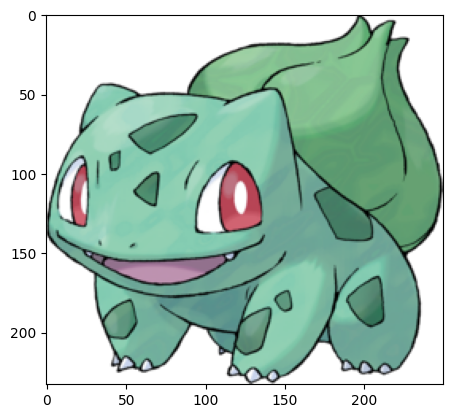

In [20]:
plt.imshow(get_image_pokemon("Bulbizarre"));

In [21]:
def save_pokemon_from_url(url : str, path : str) -> None :
  """
  Saves the image of the Pokemon resulting from the url
  of the desired image, and store it in a png file in the path
  """

  response = requests.get(url)

  if response.status_code != 200:

    raise Exception(f"Request failure with code {response.status_code}")

  with open(path, "wb") as file:

    file.write(response.content)


def save_pokemon(pokemon : str, path : str) -> None :
  """
  Saves the desired Pokemon in the path
  """
  save_pokemon_from_url(get_url(pokemon), path)

In [22]:
for i,pokemon in enumerate(tqdm(df_text["Nom français"].values)) :
  save_pokemon(pokemon,f"{path_image}{i+1:04}_{pokemon}.png")

100%|██████████| 1025/1025 [24:27<00:00,  1.43s/it]


### Part 3: Downloading the results

In [31]:
if path_image.endswith('/'):
    path_image = path_image[:-1]

zip_file_name = f"{path_image}.zip"
zip_command = f"zip -r -q {zip_file_name} {path_image}"
get_ipython().system(zip_command);

In [35]:
files.download(zip_file_name)
files.download(f"{path_df_text}.parquet")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>